## Compare learning trajectories on LLaMa 7b, 13b, and 70b
### Generate 3D animations of InPCA embedding

In [1]:

import sys
import os
from pathlib import Path

import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
sys.path.append("../models")
processed_series_path = Path(parent_dir) / 'processed_series'
# processed_series_path = Path(parent_dir) / '..' / 'llmICL' / 'processed_series'
import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output

print(sys.path)
from ICL import MultiResolutionPDF

def average_PDF_list(PDF_list, avg_interval = 6):
    """
    rolling average over a list of hierarchy PDFs
    """
    PDF_list_averaged = []
    common_bin_center_arr = PDF_list[0].bin_center_arr
    common_bin_width_arr = PDF_list[0].bin_width_arr
    for i in range(len(PDF_list)-avg_interval):
        avg_bin_height_arr = np.average([PDF_list[i+x].bin_height_arr for x in range(avg_interval)], axis = 0)
        avg_PDF = MultiResolutionPDF()
        avg_PDF.add_bin(common_bin_center_arr, common_bin_width_arr, avg_bin_height_arr)
        PDF_list_averaged += [avg_PDF]
    return PDF_list_averaged
        
def gaussian_manifold_generator(PDF_list, sigma_list, mean_list):
    """
        PDF_list: example PDF
    """
    assert len(sigma_list) == len(mean_list), "Sigma list and mean list must be of the same length"
    PDF_manifold_list = copy.deepcopy(PDF_list[:len(sigma_list)])
    for i, (sigma, mean) in enumerate(zip(sigma_list, mean_list)):
        def cdf(x):
            return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))
        PDF_manifold_list[i].discretize(cdf, mode = 'cdf')
        
    return PDF_manifold_list
    
def temperature_manifold_generator(true_PDF, temperature_list):
    PDF_manifold_list = [copy.deepcopy(true_PDF) for _ in temperature_list]
    for i, alpha in enumerate(temperature_list):
        # PDF_manifold_list[i].bin_height_arr += 0.01
        PDF_manifold_list[i].rescale_temperature(alpha)
    return PDF_manifold_list

def geodesic_from_true_stat(PDF_list, true_stat, geodesic_steps = 20):
    """
        PDF_list: example PDF
        true_stat: statistics of true distribution
    """

    PDF_geodesic_list = copy.deepcopy(PDF_list[:geodesic_steps])
    PDF_ignorance = copy.deepcopy(PDF_list[0])
    def cdf(x):
        return np.clip(x / 10, 0, 1)
    PDF_ignorance.discretize(cdf, mode = "cdf")

    PDF_true = copy.deepcopy(PDF_list[-1])
    
    if true_stat['true_PDF'] is not None:
        PDF_true = true_stat['true_PDF']        
    else:
        if true_stat['dist type'] == 'gaussian':
            def cdf(x):
                return 0.5 * (1 + erf((x - true_stat['rescaled_true_mean']) / (true_stat['rescaled_true_sigma'] * np.sqrt(2))))
        elif true_stat['dist type'] == 'uniform':
            low = true_stat['rescaled_true_mean'] - true_stat['rescaled_true_sigma']
            high = true_stat['rescaled_true_mean'] + true_stat['rescaled_true_sigma']
            def cdf(x):
                return np.where((x >= low) & (x <= high), (x - low) / (high - low), np.where(x < low, 0, 1))
        PDF_true.discretize(cdf, mode = "cdf")


    PDF_ignorance_sqrt = np.sqrt(PDF_ignorance.bin_height_arr)
    PDF_true_sqrt = np.sqrt(PDF_true.bin_height_arr)
    dG = np.arccos(1-PDF_true.Hel_dist(PDF_ignorance)**2/2)
    denom = np.sin(dG)
    for i in range(geodesic_steps):
        a = i/geodesic_steps
        u_coef = np.sin((1-a)*dG)/denom
        v_coef = np.sin(a*dG)/denom
        PDF_geodesic_list[i].bin_height_arr = np.square(u_coef * PDF_ignorance_sqrt + v_coef * PDF_true_sqrt)
    return PDF_geodesic_list        
    

['/home/admin-quad/Toni/LLMICL_inPCA/inPCA', '/home/admin-quad/anaconda3/envs/LLM/lib/python311.zip', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/lib-dynload', '', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/site-packages', '/home/admin-quad/LLM/llama', '/home/admin-quad/Toni/LLMICL_inPCA', '../models']


In [2]:
all_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
for index, file in enumerate(all_files):
    series_dict = pickle.load(file.open('rb'))
    llama_size = series_dict['llama_size']
    random_seed = series_dict['random_seed']
    kernel = series_dict.get('kernel', '')
    print(f"[{index}]: {file.name}, {llama_size}, {random_seed}, {kernel}")

[0]: uncorrelated_gaussian_centered_sigma_0.1_0.pkl, 13b, 2, 
[1]: uncorrelated_gaussian_centered_sigma_0.1_1.pkl, 13b, 3, 
[2]: uncorrelated_gaussian_centered_sigma_0.1_2.pkl, 7b, 2, 
[3]: uncorrelated_gaussian_centered_sigma_0.1_3.pkl, 7b, 3, 
[4]: uncorrelated_gaussian_centered_sigma_0.1_4.pkl, 70b, 2, 
[5]: uncorrelated_gaussian_centered_sigma_0.1_5.pkl, 70b, 3, 
[6]: uncorrelated_gaussian_centered_sigma_0.1_KDE_0.pkl, KDE, 2, gaussian
[7]: uncorrelated_gaussian_centered_sigma_0.1_KDE_1.pkl, KDE, 3, gaussian
[8]: uncorrelated_gaussian_centered_sigma_0.1_KDE_10.pkl, KDE, 2, cosine
[9]: uncorrelated_gaussian_centered_sigma_0.1_KDE_11.pkl, KDE, 3, cosine
[10]: uncorrelated_gaussian_centered_sigma_0.1_KDE_12.pkl, KDE, 2, gaussian
[11]: uncorrelated_gaussian_centered_sigma_0.1_KDE_13.pkl, KDE, 2, gaussian
[12]: uncorrelated_gaussian_centered_sigma_0.1_KDE_14.pkl, KDE, 2, gaussian
[13]: uncorrelated_gaussian_centered_sigma_0.1_KDE_15.pkl, KDE, 2, gaussian
[14]: uncorrelated_gaussian_cent

[84]: uncorrelated_random_PDF_l_0.02_KDE_22.pkl, KDE, 9, gaussian
[85]: uncorrelated_random_PDF_l_0.02_KDE_23.pkl, KDE, 9, gaussian
[86]: uncorrelated_random_PDF_l_0.02_KDE_24.pkl, KDE, 9, gaussian
[87]: uncorrelated_random_PDF_l_0.02_KDE_25.pkl, KDE, 11, gaussian
[88]: uncorrelated_random_PDF_l_0.02_KDE_26.pkl, KDE, 11, gaussian
[89]: uncorrelated_random_PDF_l_0.02_KDE_27.pkl, KDE, 11, gaussian
[90]: uncorrelated_random_PDF_l_0.02_KDE_28.pkl, KDE, 11, gaussian
[91]: uncorrelated_random_PDF_l_0.02_KDE_29.pkl, KDE, 13, gaussian
[92]: uncorrelated_random_PDF_l_0.02_KDE_3.pkl, KDE, 0, gaussian
[93]: uncorrelated_random_PDF_l_0.02_KDE_30.pkl, KDE, 13, gaussian
[94]: uncorrelated_random_PDF_l_0.02_KDE_31.pkl, KDE, 13, gaussian
[95]: uncorrelated_random_PDF_l_0.02_KDE_32.pkl, KDE, 13, gaussian
[96]: uncorrelated_random_PDF_l_0.02_KDE_33.pkl, KDE, 15, gaussian
[97]: uncorrelated_random_PDF_l_0.02_KDE_34.pkl, KDE, 15, gaussian
[98]: uncorrelated_random_PDF_l_0.02_KDE_35.pkl, KDE, 15, gaussian


In [3]:
alpha = 1
avg_interval = 2
geodesic_steps = 40
gaussian_manifold_steps = geodesic_steps
gaussian_manifold = 1
temperature_manifold = 0
### If true, then keep only 1 true statistic
use_true_PDF = 0

In [4]:
import re
def find_file(files, llama_size=None, sigma=None, kernel=None, random_seed=None, bw_function_name=None, dist_type=None):
    for file in files:
        matches = True
        
        # Extract sigma from filename
        sigma_match = re.search(r'sigma_([\d.]+)', file.name)
        file_sigma = float(sigma_match.group(1)) if sigma_match else None
        
        series_dict = pickle.load(file.open('rb'))
        
        # Check llama_size
        if llama_size is not None and series_dict.get('llama_size') != llama_size:
            matches = False
        
        # Check sigma
        if sigma is not None and file_sigma != sigma:
            matches = False
        
        # Check kernel
        if kernel is not None and series_dict.get('kernel', '') != kernel:
            matches = False
        
        # Check random_seed
        if random_seed is not None and series_dict.get('random_seed') != random_seed:
            matches = False
            
        # check distribution type
        # Check distribution type
        if dist_type is not None:
            if dist_type not in file.name:
                matches = False
        
        # Check bw_function_name
        if bw_function_name is not None:
            if 'bw_function_name' not in series_dict or series_dict['bw_function_name'] != bw_function_name:
                matches = False
        if bw_function_name is None:
            if 'bw_function_name' in series_dict:
                matches = False
        
        if matches:
            return file
    return None

In [1]:

if gaussian_manifold and temperature_manifold:
    raise ValueError("Cannot plot both gaussian and temperature manifolds simultaneously")

PDF_list_multi_traj = []
true_statistics = []
traj_names = []
default_dist = 'gaussian'
remove_redundant_stat = True


############################################################################################################
############################################################################################################


# PDF_slice = slice(0,200)
# color_list = ["C1", "C0", "C2", "C1", "C0", "C2"]
# marker_list = [ "s","o","^","s","o","^"]
# # marker_list = ["s", "^", "o", "D", "p", "*", "H", "v", ">", "<", "8", "d"]
# # name = f"../paper_figures/gaussian_0.1_0.3_7_13_70_KDE_hist"
# name = f"../paper_figures/gaussian_0.1_7_13_70_KDE_hist"
# selected_files = [
    
#     find_file(all_files, llama_size='7b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='70b', sigma=0.1, kernel=None),
#     # find_file(all_files, llama_size='7b', sigma=0.3, kernel=None),
#     # find_file(all_files, llama_size='13b', sigma=0.3, kernel=None),
#     # find_file(all_files, llama_size='70b', sigma=0.3, kernel=None),

# ]


############################################################################################################
############################################################################################################


# PDF_slice = slice(0,100)
# color_list = ["C1", "C0", "C2", "C1", "C0", "C2"]
# marker_list = [ "s","o","^","s","o","^"]
# # marker_list = ["s", "^", "o", "D", "p", "*", "H", "v", ">", "<", "8", "d"]
# name = f"../paper_figures/gaussian_0.1_0.3_7_13_70_KDE_hist"
# selected_files = [
    
#     find_file(all_files, llama_size='7b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='70b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='7b', sigma=0.3, kernel=None),
#     find_file(all_files, llama_size='13b', sigma=0.3, kernel=None),
#     find_file(all_files, llama_size='70b', sigma=0.3, kernel=None),

# ]

############################################################################################################
############################################################################################################

# PDF_slice = slice(0,390)
# color_list = ["C1", "C0", "C2", "C3", "C4"]
# name = f"../paper_figures/gaussian_0.1_7_13_70_KDE_hist"
# selected_files = [
    
#     find_file(all_files, llama_size='7b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='70b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian'),
#     find_file(all_files, llama_size='histogram', sigma=0.1, kernel=None),
# ]

############################################################################################################
############################################################################################################

PDF_slice = slice(0,200)
color_list = ["C1", "C0", "C2", "C3", "C4"]
name = f"../paper_figures/uniform_0.1_7_13_70_KDE_hist"
selected_files = [
    
    find_file(all_files, llama_size='7b', sigma=0.1, kernel=None, dist_type = 'uniform'),
    find_file(all_files, llama_size='13b', sigma=0.1, kernel=None, dist_type = 'uniform'),
    find_file(all_files, llama_size='70b', sigma=0.1, kernel=None, dist_type = 'uniform'),
    find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian', dist_type = 'uniform'),
    find_file(all_files, llama_size='histogram', sigma=0.1, kernel=None, dist_type = 'uniform'),
]

############################################################################################################
############################################################################################################

# PDF_slice = slice(0,200)
# color_list = [ "C0", "C0", "C0"]
# name = f"../paper_figures/uniform_0.1_0.3_0.5_13b"
# selected_files = [
    
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='13b', sigma=0.3, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='13b', sigma=0.5, kernel=None, dist_type = 'uniform'),
#     # find_file(all_files, llama_size='KDE', sigma=0.3, kernel='gaussian', dist_type = 'uniform'),
#     # find_file(all_files, llama_size='histogram', sigma=0.3, kernel=None, dist_type = 'uniform'),
# ]


############################################################################################################
############################################################################################################
# PDF_slice = slice(0,200)
# remove_redundant_stat = True
# default_dist = 'gaussian'
# grouping = [[2,7,8],
#             [1,5,6],
#             [0,3,4]]
# geodesic_grouping = [2,1,0]

# avg_interval = 4
# color_list = ["C0", "C0", "C0","C3", "C4","C3", "C4","C3", "C4"]
# marker_list = [ "s","s","s","o","^","o","^","o","^"]
# name = f"../paper_figures/gaussian_0.3_0.1_7b_13b_70b_seed3"
# selected_files = [
    
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='13b', sigma=0.3, kernel=None),
#     find_file(all_files, llama_size='13b', sigma=0.5, kernel=None),
#     find_file(all_files, llama_size='KDE', sigma=0.1),
#     find_file(all_files, llama_size='histogram', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='KDE', sigma=0.3),
#     find_file(all_files, llama_size='histogram', sigma=0.3, kernel=None),
#     find_file(all_files, llama_size='KDE', sigma=0.5),
#     find_file(all_files, llama_size='histogram', sigma=0.5, kernel=None),
# ]

############################################################################################################
############################################################################################################

# default_dist = 'uniform'
# PDF_slice = slice(0,200)
# grouping = [[2,7,8],
#             [1,5,6],
#             [0,3,4]]
# geodesic_grouping = [0,1,2]
# avg_interval = 4
# color_list = ["C0", "C0", "C0","C3", "C4","C3", "C4","C3", "C4"]
# marker_list = [ "s","s","s","o","^","o","^","o","^"]
# name = f"../paper_figures/uniform_0.5_0.3_0.1_7b_13b_KDE_hist"
# selected_files = [
    
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='13b', sigma=0.3, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='13b', sigma=0.5, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='KDE', sigma=0.1, dist_type = 'uniform'),
#     find_file(all_files, llama_size='histogram', sigma=0.1, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='KDE', sigma=0.3, dist_type = 'uniform'),
#     find_file(all_files, llama_size='histogram', sigma=0.3, kernel=None, dist_type = 'uniform'),
#     find_file(all_files, llama_size='KDE', sigma=0.5, dist_type = 'uniform'),
#     find_file(all_files, llama_size='histogram', sigma=0.5, kernel=None, dist_type = 'uniform'),
# ]


############################################################################################################
############################################################################################################


default_dist = 'uniform'
PDF_slice = slice(0,200)
grouping = [[2,7,8],
            [1,5,6],
            [0,3,4]]
geodesic_grouping = [0,1,2]
avg_interval = 4
color_list = ["C0", "C0", "C0","C3", "C4","C3", "C4","C3", "C4"]
marker_list = [ "s","s","s","o","^","o","^","o","^"]
name = f"../paper_figures/uniform_0.5_0.2_0.1_7b_13b_KDE_hist"
selected_files = [
    
    find_file(all_files, llama_size='13b', sigma=0.1, kernel=None, dist_type = 'uniform'),
    find_file(all_files, llama_size='13b', sigma=0.2, kernel=None, dist_type = 'uniform'),
    find_file(all_files, llama_size='13b', sigma=0.5, kernel=None, dist_type = 'uniform'),
    find_file(all_files, llama_size='KDE', sigma=0.1, dist_type = 'uniform'),
    find_file(all_files, llama_size='histogram', sigma=0.1, kernel=None, dist_type = 'uniform'),
    find_file(all_files, llama_size='KDE', sigma=0.2, dist_type = 'uniform'),
    find_file(all_files, llama_size='histogram', sigma=0.2, kernel=None, dist_type = 'uniform'),
    find_file(all_files, llama_size='KDE', sigma=0.5, dist_type = 'uniform'),
    find_file(all_files, llama_size='histogram', sigma=0.5, kernel=None, dist_type = 'uniform'),
]


############################################################################################################
############################################################################################################


# PDF_slice = slice(0,200)
# grouping = None
# geodesic_grouping = None
# avg_interval = 4
# color_list = ["C0", "C5", "C3", "C6", "C7", "C8"]
# marker_list = ["s", "^", "o", "D", "p", "*", "H", "v", ">", "<", "8", "d"]
# name = f"../paper_figures/gaussian_multi_kernels"

# selected_files = [
    
#     find_file(all_files, llama_size='13b', sigma=0.1, kernel=None),
#     find_file(all_files, llama_size='KDE', sigma=0.1, kernel='exponential', bw_function_name=None),
#     find_file(all_files, llama_size='KDE', sigma=0.1, kernel='gaussian'),
#     find_file(all_files, llama_size='KDE', sigma=0.1, kernel='epanechnikov'),
# ]

# ###########################################################################################################
# ###########################################################################################################


# Remove any None values in case a file wasn't found
selected_files = [f for f in selected_files if f is not None]
print(selected_files)



for file in selected_files:
    processed_dict = pickle.load(file.open('rb'))
    PDF_list_multi_traj.append(processed_dict['PDF_list'])
    llama_size = processed_dict['llama_size']
    kernel = processed_dict.get('kernel', None)
    bw_function_name = processed_dict.get('bw_function_name', None)
    if kernel is not None:
        traj_name = f"{llama_size}_{kernel}"
        if bw_function_name is not None:
            traj_name += f"_{bw_function_name}"
        traj_names += [traj_name]
    else:
        traj_names += [f"{llama_size}"]
    true_stat = {
        'dist type':  processed_dict.get('dist type', default_dist),
        'rescaled_true_mean': processed_dict.get('rescaled_true_mean_arr', [None])[-1],
        'rescaled_true_sigma': processed_dict.get('rescaled_true_sigma_arr',[None])[-1],
        'true_PDF': processed_dict.get('true_PDF',None)
    }
    true_statistics.append(true_stat)


if use_true_PDF:
    true_PDF = true_statistics[0]['true_PDF']
    true_statistics = true_statistics[0:1]
else:
    # remove repeated true statistics
    seen = set()
    unique_true_statistics = []
    for d in true_statistics:
        t = tuple(d.items())
        if t not in seen:
            seen.add(t)
            unique_true_statistics.append(d)
    true_statistics = unique_true_statistics

NameError: name 'gaussian_manifold' is not defined

In [ ]:


name_convert_dict = {'7b':'LLaMA-2 7b', '13b':'LLaMA-2 13b', '70b':'LLaMA-2 70b', 'KDE_gaussian': 'gaussian KDE', 'histogram_NA': "histogram", 'KDE_exponential': 'exponential KDE', 'KDE_tophat': 'tophat KDE',
                     'KDE_epanechnikov': 'epanechnikov KDE'}
traj_names = [name_convert_dict.get(name, name) for name in traj_names]
print(traj_names)


['LLaMA-2 13b', 'LLaMA-2 13b', 'gaussian KDE', 'histogram', 'gaussian KDE', 'histogram']


In [ ]:
true_statistics

[{'dist type': 'uniform',
  'rescaled_true_mean': 5.0,
  'rescaled_true_sigma': 0.3571428571428571,
  'true_PDF': None},
 {'dist type': 'uniform',
  'rescaled_true_mean': 5.0,
  'rescaled_true_sigma': 1.0714285714285712,
  'true_PDF': None},
 {'dist type': 'uniform',
  'rescaled_true_mean': 5.0,
  'rescaled_true_sigma': 1.7857142857142856,
  'true_PDF': None}]

In [ ]:
### tune temperature and sort by bin center
for PDF_list in PDF_list_multi_traj:
    for PDF in PDF_list:
        PDF.sort_by_center()
        if alpha != 1:
            PDF.rescale_temperature(alpha)
            
### average over steps
for i in range(len(PDF_list_multi_traj)):
    PDF_list_multi_traj[i] = average_PDF_list(PDF_list_multi_traj[i], avg_interval = avg_interval)

In [ ]:
### Calculate geodesic 
PDF_geodesic_list_multi_traj = []
example_PDF_list = PDF_list_multi_traj[0]
for true_stat in true_statistics:
    PDF_geodesic_list_multi_traj += [geodesic_from_true_stat(example_PDF_list,
                                                             true_stat,
                                                             geodesic_steps=geodesic_steps)]

In [ ]:
### Calculate gaussian sub-manifold:
if gaussian_manifold:
    # same length as geodesic, for easy plotting
    sigma_list = np.linspace(0,5,gaussian_manifold_steps)
    mean_list = np.array([5]*gaussian_manifold_steps)
    PDF_list = PDF_list_multi_traj[0]
    sub_manifold_list = gaussian_manifold_generator(PDF_list, sigma_list, mean_list)
    PDF_geodesic_list_multi_traj += [sub_manifold_list]
    
    # %matplotlib inline 
    # from ipywidgets import interact
    # def plotter(idx):
    #     fig=plt.figure(figsize = (5,1))
    #     ax = fig.add_subplot(111)
    #     sub_manifold_list[idx].plot(ax=ax, statistic = False)

    # interact(plotter, idx=(0, geodesic_steps-1, 1))

/tmp/ipykernel_93395/2799490784.py:46: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))
/tmp/ipykernel_93395/2799490784.py:46: RuntimeWarning: invalid value encountered in divide
  return 0.5 * (1 + erf((x - mean) / (sigma * np.sqrt(2))))


In [ ]:
### Calculate temperature sub-manifold:
if temperature_manifold:
    temperature_list = np.logspace(np.log10(1), np.log10(20), geodesic_steps)
    sub_manifold_list = temperature_manifold_generator(true_PDF, temperature_list)
    PDF_geodesic_list_multi_traj += [sub_manifold_list]
    
    %matplotlib inline 
    from ipywidgets import interact
    def plotter(idx):
        fig=plt.figure(figsize = (5,1))
        ax = fig.add_subplot(111)
        sub_manifold_list[idx].plot(ax=ax, statistic = False)

    interact(plotter, idx=(0, geodesic_steps-1, 1))

In [ ]:

traj_len = PDF_slice.stop - PDF_slice.start
PDF_emb_list = []
for PDF_list in PDF_list_multi_traj:
    PDF_emb_list += PDF_list[PDF_slice]

for i, geodesic_list in enumerate(PDF_geodesic_list_multi_traj):
    if i == 0:
        PDF_emb_list += geodesic_list
    else:
        PDF_emb_list += geodesic_list[1:]
        

### Compute pair-wise distance

In [ ]:
import numpy as np

# Initialize the matrix D with zeros. The size of the matrix is determined by the length of PDF_list.
num_PDFs = len(PDF_emb_list)




In [ ]:
# # Populate the upper triangle of the matrix with the BT distances.
# D_Hel = np.zeros((num_PDFs, num_PDFs))
# for i in range(num_PDFs):
#     for j in range(i+1, num_PDFs):  # Start from i+1 to avoid computing the distance of an object with itself
#         D_Hel[i, j] = PDF_emb_list[j].Hel_dist(PDF_emb_list[i])

In [ ]:
### parallelized

# use_L2 = True
use_L2 = False

import numpy as np
from multiprocessing import Pool, cpu_count

def compute_distance(args):
    i, j, PDF_i, PDF_j = args
    if use_L2:
        return (i, j, np.sqrt(PDF_j.L2_dist(PDF_i)))
    else:
        return (i, j, PDF_j.Hel_dist(PDF_i))

def parallel_distance_matrix(PDF_emb_list):
    num_PDFs = len(PDF_emb_list)
    D_Hel = np.zeros((num_PDFs, num_PDFs))
    
    # Prepare arguments for parallel processing
    args = [(i, j, PDF_emb_list[i], PDF_emb_list[j]) 
            for i in range(num_PDFs) 
            for j in range(i+1, num_PDFs)]
    
    # Use all available CPU cores
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(compute_distance, args)
    
    # Fill the matrix with the results
    for i, j, distance in results:
        D_Hel[i, j] = distance
    
    return D_Hel

# Use the function
D_Hel = parallel_distance_matrix(PDF_emb_list)

In [ ]:
plt.imshow(D_Hel)

In [ ]:
# Copy the upper triangle to the lower triangle to make the matrix symmetric.
# truncate
D_BT = -np.log(1-np.square(D_Hel)/2)
D_Hel = D_Hel + D_Hel.T
D_BT = D_BT + D_BT.T

P = np.eye(num_PDFs) - np.ones(num_PDFs)/num_PDFs
XXT_Hel = -P @ np.square(D_Hel) @ P
XXT_BT = -P @ D_BT @ P

### Hellinger Embedding

array([328.80620748, 250.39019103,  64.01996018])

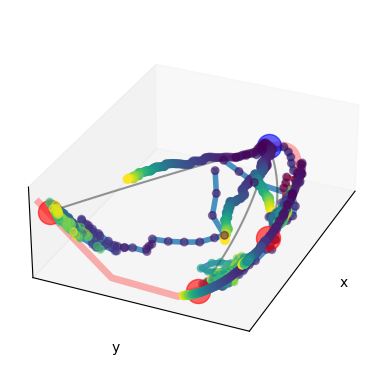

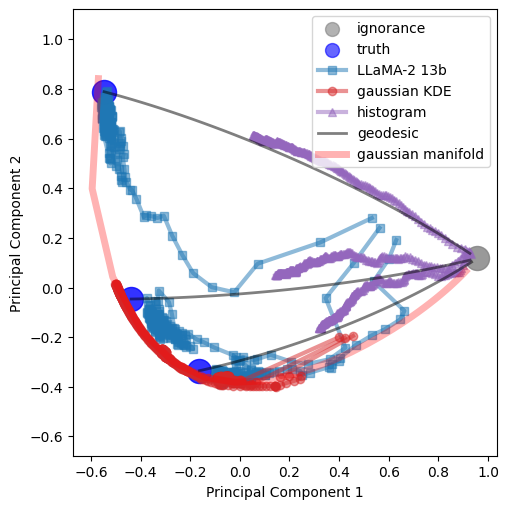

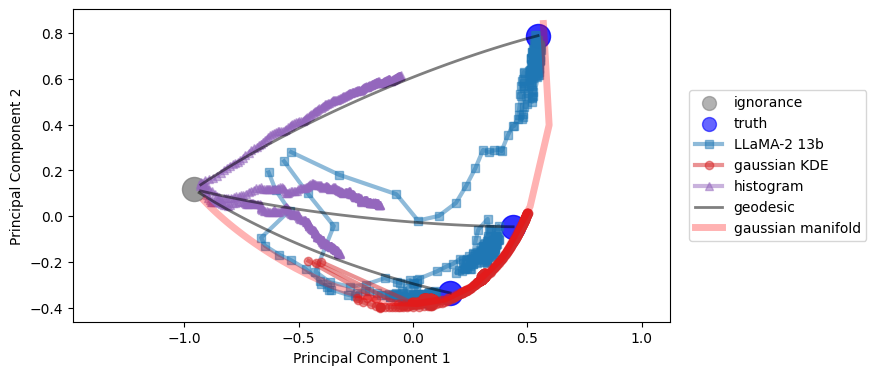

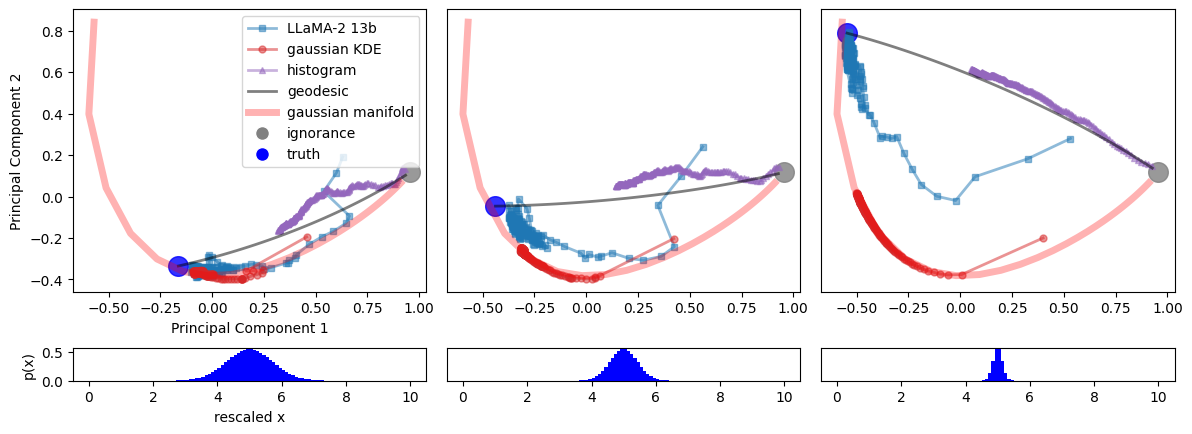

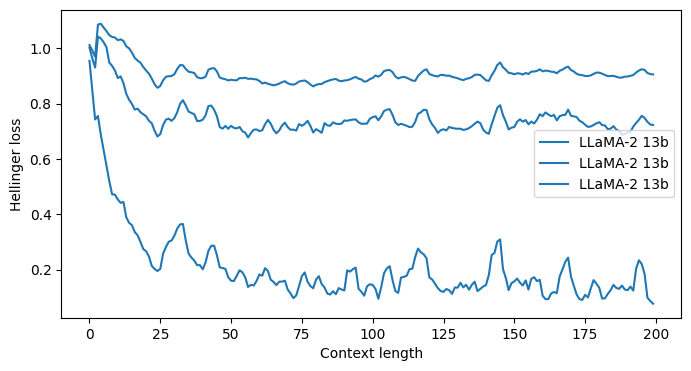

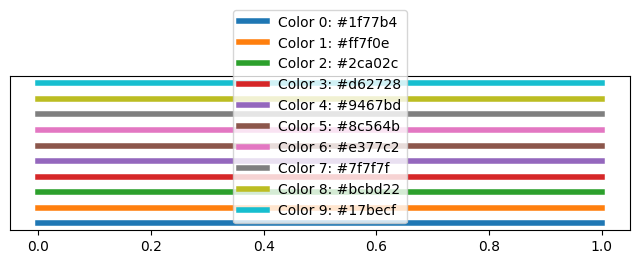

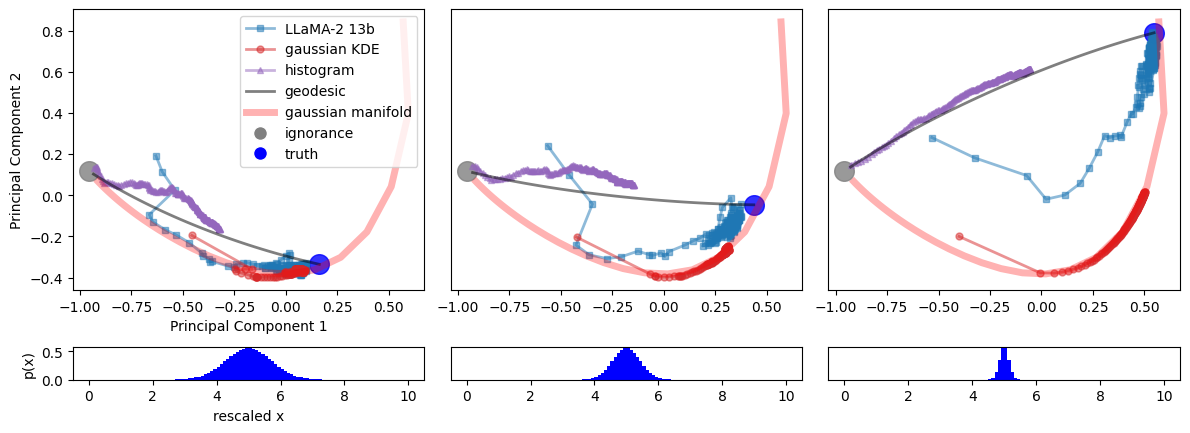

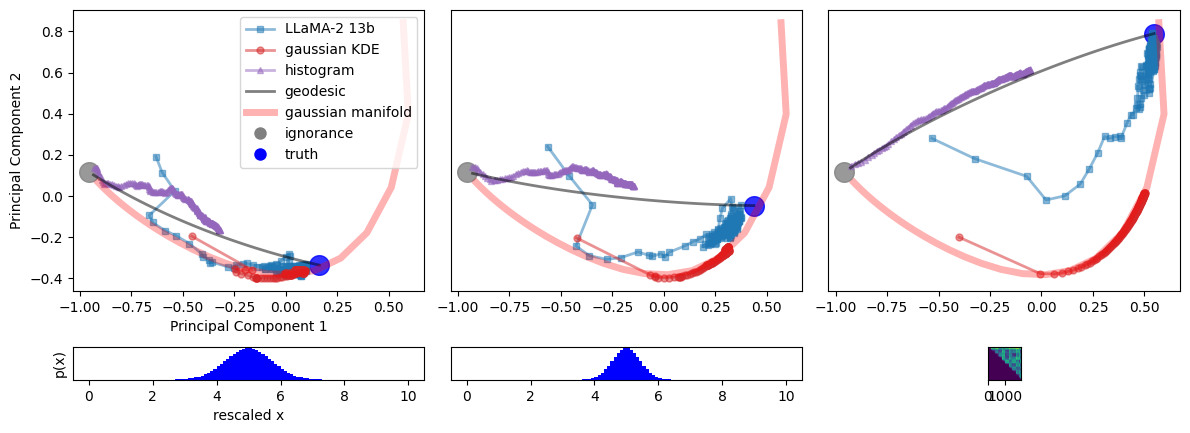

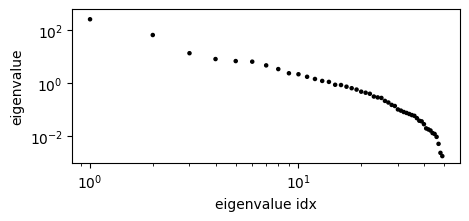

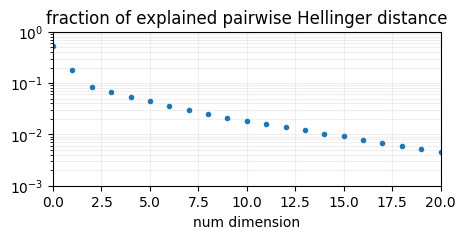

In [ ]:
sigma, U = np.linalg.eigh(XXT_Hel)
# Reorder sigma and U based on the absolute value of sigma in decreasing order
idx = np.argsort(np.abs(sigma))[::-1]
sigma = sigma[idx]
U = U[:, idx]
U_rescaled = U * np.sqrt(np.abs(sigma))
U_rescaled_original = U_rescaled.copy()
# U_rescaled = U * sigma

%matplotlib inline 
# Plot with color based on the sign of sigma
spectrum_cutoff = 50
colors = ['black' if value > 0 else 'red' for value in sigma[:spectrum_cutoff]]
plt.figure(figsize=(5,2), dpi=100)
plt.scatter(range(spectrum_cutoff), np.abs(sigma[:spectrum_cutoff]), c=colors, s = 5)
plt.xlabel('eigenvalue idx')
plt.ylabel('eigenvalue')
plt.xscale('log')
plt.yscale('log')



total_var = np.sum(np.abs(sigma))
explained_var = np.cumsum(np.abs(sigma))

plt.figure(figsize=(5,2), dpi=100)
plt.xlim(0, 20)
plt.plot(1-explained_var/total_var, marker = '.', lw =0)
plt.xlabel('num dimension')
plt.title('fraction of explained pairwise Hellinger distance')
# Set x-axis to log scale
# plt.xscale('log')

# Set y-axis to log scale
plt.yscale('log')

# Adjust y-axis limits to accommodate log scale
plt.ylim(0.001, 1)


# Add grid for better readability in log scale
plt.grid(True, which="both", ls="-", alpha=0.2)

sigma[:3]

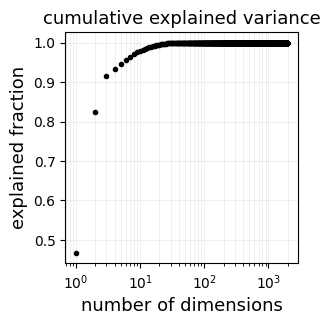

In [ ]:
plt.figure(figsize=(3,3), dpi=100)
plt.plot(range(1, len(explained_var)+1), explained_var/total_var, marker='.', lw=0, color='black')
plt.xlabel('number of dimensions', fontsize=13)
plt.ylabel('explained fraction', fontsize=13)
plt.title('cumulative explained variance', fontsize=13)
plt.xscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)

### 3D Embedding

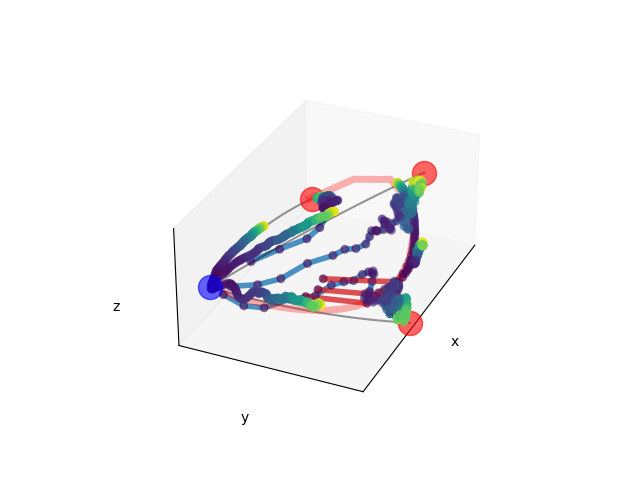

In [ ]:
interactive = 1

time_cutoff = -geodesic_steps
interval = 1
geodesic = True
shadows = 0
shadow_alpha = 0.05

num_geodesics = len(PDF_geodesic_list_multi_traj)
num_trajs = len(PDF_list_multi_traj)

submanifold = gaussian_manifold or temperature_manifold

filenames = []

def plotter_with_initial_angle(angle, save_path = None):

    if interactive:
        #interactive 3D plot
        %matplotlib widget 
        fig = plt.figure(dpi = 100)
    else:    
    # static 3D plot
        %matplotlib inline 
        fig = plt.figure(dpi = 100, figsize=(8,8))
        
    ax = fig.add_subplot(111, projection='3d')

    for i in range(num_trajs):
        # learning trajectories
        ax.scatter3D(U_rescaled[i*traj_len:(i+1)*traj_len:interval,0], U_rescaled[i*traj_len:(i+1)*traj_len:interval,1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,2], c=range(int(traj_len/interval)), s = 30, alpha = 0.5)
        ax.plot(U_rescaled[i*traj_len:(i+1)*traj_len:interval,0], U_rescaled[i*traj_len:(i+1)*traj_len:interval,1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,2], alpha = 0.8, lw = 4, c = color_list[i])

    # ignorance is the shared
    ign_index = num_trajs * traj_len
    ax.scatter3D(U_rescaled[ign_index,0], U_rescaled[ign_index,1], U_rescaled[ign_index,2], c='blue', s = 300, alpha = 0.6)

    for i in range(num_geodesics-submanifold):
        # geodesics
        start = ign_index+i*(geodesic_steps-1)+1
        end = ign_index+(i+1)*(geodesic_steps-1)+1
        ax.scatter3D(U_rescaled[end-1,0], U_rescaled[end-1,1], U_rescaled[end-1,2], c='red', s = 300, alpha = 0.6)
        if geodesic:
            ax.plot(U_rescaled[start : end,0], 
                    U_rescaled[start : end,1],
                    U_rescaled[start : end,2], c='black', alpha = 0.4)

    if gaussian_manifold:
        # gaussian manifold
        start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
        end = ign_index+num_geodesics*(geodesic_steps-1)+1
        ax.plot(U_rescaled[start : end,0], U_rescaled[start : end,1], U_rescaled[start : end,2], c='red', alpha = 0.3, lw = 5, label = "gaussian manifold")

    if temperature_manifold:
        # gaussian manifold
        start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
        end = ign_index+num_geodesics*(geodesic_steps-1)+1
        ax.plot(U_rescaled[start : end,0], U_rescaled[start : end,1], U_rescaled[start : end,2], c='red', alpha = 0.3, lw = 5, label = "temperature manifold")


    # if not interactive:
    #     ax.legend()
            
            
    x_min, x_max = U_rescaled[:,0].min(), U_rescaled[:,0].max()
    y_min, y_max = U_rescaled[:,1].min(), U_rescaled[:,1].max()
    z_min, z_max = U_rescaled[:,2].min(), U_rescaled[:,2].max()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)

    if shadows:
        for zdir, zs, idx_tuple in zip(['x','y','z'],[x_min, y_max, z_min],[(1,2),(0,2),(0,1)]):        
            for i in range(len(PDF_list_multi_traj)):
                ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,idx_tuple[0]], U_rescaled[i*traj_len:(i+1)*traj_len:interval,idx_tuple[1]], c=range(int(traj_len/interval)), alpha = shadow_alpha, zs=zs, zdir=zdir)

        
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_zticks([])

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(elev=30, azim=angle)
    # plt.title(f"fraction of explained variance {explained_var[2]/total_var*100:.0f}%")
    # plt.axis('equal')
    ax.set_aspect('equal')
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        filenames.append(save_path)
        plt.close(fig)  # Save the plot without displaying it
    
    
plotter_with_initial_angle(angle = 24)    

### Animate

In [ ]:
# filenames = []
# num_frames = 300
# for frame_idx in range(num_frames):
#     angle = 2 * 360 * (frame_idx/num_frames)
#     save_path = f"../figures/animation/{frame_idx}.png"
#     plotter_with_initial_angle(angle = angle, save_path = save_path)    

In [ ]:
# # Create a GIF using snapshot made
# import imageio.v2 as imageio
# remark = name.split("/")[-1]
# with imageio.get_writer(f'../figures/{remark}.gif', mode='I', duration=30000 / num_frames, loop=0) as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)
#         os.remove(filename)

### 2D Embedding


In [ ]:
invert_x = 1
invert_y = 1

fraction of explained variance 82%


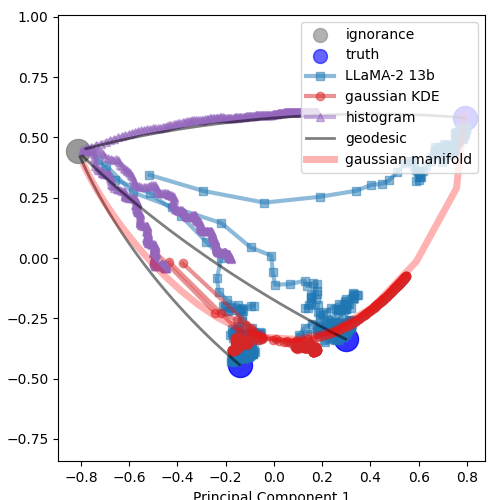

In [ ]:
dim1 = 0
dim2 = 1
U_rescaled = U_rescaled_original.copy() 
if invert_x:
    U_rescaled[:,dim1] = -U_rescaled[:,dim1]
if invert_y:
    U_rescaled[:,dim2] = -U_rescaled[:,dim2]


fig = plt.figure(dpi = 100, figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter([],[], c='gray', s = 100, alpha = 0.6, label = 'ignorance')
ax.scatter([],[], c='blue', s = 100, alpha = 0.6, label = 'truth')
for i in range(len(PDF_list_multi_traj)):    
    # ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], c=range(int(traj_len/interval)), alpha = 0.5)
    # ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], c = color_list[i], alpha = 0.5)
    ax.plot(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], alpha = 0.5, lw=3, 
            label = traj_names[i], 
            c = color_list[i],
            marker = marker_list[i])

# ignorance is shared
ign_index = num_trajs * traj_len
ax.scatter(U_rescaled[ign_index,dim1], U_rescaled[ign_index,dim2], c='grey', s = 300, alpha = 0.8)
# ax.annotate('ignorance', (U_rescaled[ign_index,dim1], U_rescaled[ign_index,dim2]),textcoords="offset points", xytext=(10,10), ha='center')

for i in range(num_geodesics-submanifold):
    # geodesics
    start = ign_index+i*(geodesic_steps-1)+1
    end = ign_index+(i+1)*(geodesic_steps-1)+1
    ax.scatter(U_rescaled[end-1,dim1], U_rescaled[end-1,dim2], c='blue', s = 300, alpha = 0.8)
    if geodesic:
        ax.plot(U_rescaled[start : end,dim1], 
                U_rescaled[start : end,dim2], c='black', alpha=0.5, lw=2)


if geodesic:
    ax.plot([], c='black', alpha=0.5, lw=2, label = 'geodesic')  # Increased line width to thicken the line
# ax.scatter([],[], c='purple', alpha = 0.5, label = "LLM prediction")
  
if submanifold:
    label = "temperature manifold" if temperature_manifold else "gaussian manifold"
    start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
    end = ign_index+num_geodesics*(geodesic_steps-1)+1
    ax.plot(U_rescaled[start : end,dim1], 
                U_rescaled[start : end,dim2], c='red', alpha = 0.3, lw = 5, label = label)

# plt.xticks([])  # Turn off x-axis ticks
# plt.yticks([])  # Turn off y-axis ticks

# Invert the y-axis
# ax.invert_yaxis()


# remove repeated labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), loc='best')
# Move the legend outside the plot
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

# Adjust the layout to prevent the legend from being cut off
plt.tight_layout()
# Label x and y axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

print(f"fraction of explained variance {explained_var[1]/total_var*100:.0f}%")
plt.axis('equal')
if use_L2:
    save_path = f"{name}_L2_2D_{explained_var[1]/total_var*100:.0f}.png"
else:
    save_path = f"{name}_Hellinger_2D_{explained_var[1]/total_var*100:.0f}.png"
plt.savefig(save_path, bbox_inches='tight')  # Ensure the legend is included in the saved figure



## Figure 1 elements

In [ ]:
invert_x = 0
invert_y = 1

fraction of explained variance 82%


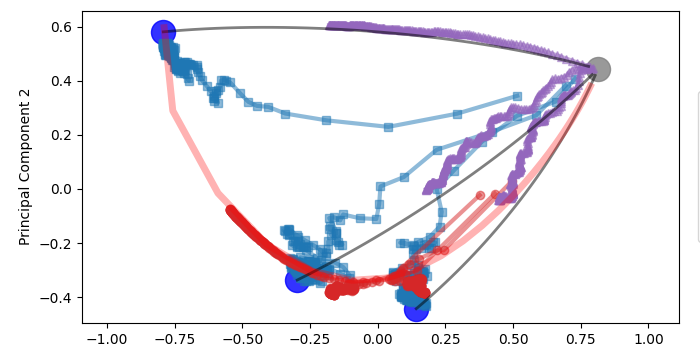

In [ ]:
dim1 = 0
dim2 = 1
U_rescaled = U_rescaled_original.copy() 
if invert_x:
    U_rescaled[:,dim1] = -U_rescaled[:,dim1]
if invert_y:
    U_rescaled[:,dim2] = -U_rescaled[:,dim2]


fig = plt.figure(dpi = 100, figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter([],[], c='gray', s = 100, alpha = 0.6, label = 'ignorance')
ax.scatter([],[], c='blue', s = 100, alpha = 0.6, label = 'truth')
for i in range(len(PDF_list_multi_traj)):    
    # ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], c=range(int(traj_len/interval)), alpha = 0.5)
    # ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], c = color_list[i], alpha = 0.5)
    ax.plot(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], alpha = 0.5, lw=3, 
            label = traj_names[i], 
            c = color_list[i],
            marker = marker_list[i])

# ignorance is shared
ign_index = num_trajs * traj_len
ax.scatter(U_rescaled[ign_index,dim1], U_rescaled[ign_index,dim2], c='grey', s = 300, alpha = 0.8)
# ax.annotate('ignorance', (U_rescaled[ign_index,dim1], U_rescaled[ign_index,dim2]),textcoords="offset points", xytext=(10,10), ha='center')

for i in range(num_geodesics-submanifold):
    # geodesics
    start = ign_index+i*(geodesic_steps-1)+1
    end = ign_index+(i+1)*(geodesic_steps-1)+1
    ax.scatter(U_rescaled[end-1,dim1], U_rescaled[end-1,dim2], c='blue', s = 300, alpha = 0.8)
    if geodesic:
        ax.plot(U_rescaled[start : end,dim1], 
                U_rescaled[start : end,dim2], c='black', alpha=0.5, lw=2)


if geodesic:
    ax.plot([], c='black', alpha=0.5, lw=2, label = 'geodesic')  # Increased line width to thicken the line
# ax.scatter([],[], c='purple', alpha = 0.5, label = "LLM prediction")
  
if submanifold:
    label = "temperature manifold" if temperature_manifold else "gaussian manifold"
    start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
    end = ign_index+num_geodesics*(geodesic_steps-1)+1
    ax.plot(U_rescaled[start : end,dim1], 
                U_rescaled[start : end,dim2], c='red', alpha = 0.3, lw = 5, label = label)


# Remove repeated labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Adjust the layout to make room for the legend
plt.tight_layout()

# Move the legend outside the plot to the right
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1.02, 0.5))

# Adjust the figure size to accommodate the legend
fig.set_size_inches(7, 3.5)  # Increase the width to make room for the legend


# Label x and y axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

print(f"fraction of explained variance {explained_var[1]/total_var*100:.0f}%")
plt.axis('equal')
if use_L2:
    save_path = f"{name}_L2_2D_{explained_var[1]/total_var*100:.0f}.png"
else:
    save_path = f"{name}_Hellinger_2D_{explained_var[1]/total_var*100:.0f}.png"
plt.savefig(save_path, bbox_inches='tight', dpi=100)  # Ensure the legend is included in the saved figure

plt.show()



In [ ]:
save_path

'../paper_figures/uniform_0.5_0.3_0.1_7b_13b_KDE_hist_Hellinger_2D_82.png'

### Duplicated 2D Plots

In [ ]:
geodesic_grouping = [2,1,0]

In [ ]:
invert_x = 1
invert_y = 1

fraction of explained variance 82%


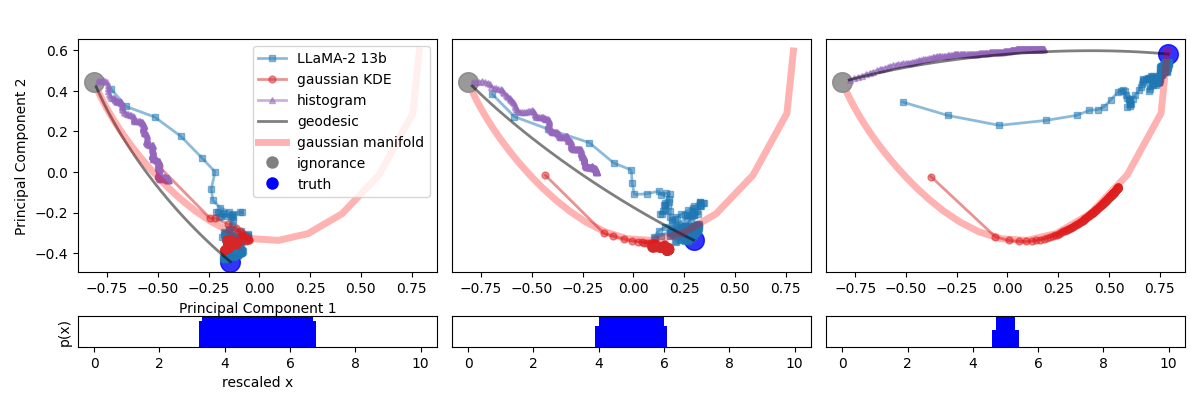

In [ ]:
U_rescaled = U_rescaled_original.copy() 
plot_truth = 1
if grouping is not None:
    n_groups = len(grouping)
    dim1 = 0
    dim2 = 1
    if invert_x:
        U_rescaled[:,dim1] = -U_rescaled[:,dim1]
    if invert_y:
        U_rescaled[:,dim2] = -U_rescaled[:,dim2]
    # Define fixed size for truth plots
    truth_height = 0.4  # in inches, make this smaller to make the truth plot narrower
    truth_width = 4   # in inches
    
    # Calculate the height of the main plots to maintain aspect ratio
    main_height = 1.4*truth_width * (max(U_rescaled[:,dim2]) - min(U_rescaled[:,dim2])) / (max(U_rescaled[:,dim1]) - min(U_rescaled[:,dim1]))
    
    # Set up the figure with regular subplots
    fig, axs = plt.subplots(2 if plot_truth else 1, n_groups, figsize=(n_groups * truth_width, main_height + (truth_height if plot_truth else 0)), dpi=100, gridspec_kw={'height_ratios': [main_height, truth_height] if plot_truth else [main_height]})
    
    if not plot_truth:
        axs = np.expand_dims(axs, axis=0)  # Ensure axs is always 2D array for consistency

    if plot_truth:
        # Share y-axis for truth plots
        for ax in axs[1, 1:]:
            # ax.sharey(axs[1, 0])
            ax.yaxis.set_visible(False)

    # Create a list to store legend handles and labels
    legend_handles = []
    legend_labels = []

    for subplot_idx, (group, geodesic_idx) in enumerate(zip(grouping, geodesic_grouping)):
        ax = axs[0, subplot_idx]
        if plot_truth:
            ax_truth = axs[1, subplot_idx]
        
        for i in group:
            mk = marker_list[i]
            # scatter = ax.scatter(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], 
            #            U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], 
            #            c=color_list[i], alpha=0.4, s=10)
            line, = ax.plot(U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim1], 
                    U_rescaled[i*traj_len:(i+1)*traj_len:interval,dim2], 
                    alpha=0.5, lw=2, c=color_list[i], marker=mk, markersize=5)
            
            # Add to legend only if not already added
            if traj_names[i] not in legend_labels:
                legend_handles.append(line)
                legend_labels.append(traj_names[i])

        # ignorance is shared
        ign_index = num_trajs * traj_len
        ax.scatter(U_rescaled[ign_index,dim1], U_rescaled[ign_index,dim2], c='gray', s=200, alpha=0.8)

        # geodesics (only plot the specified geodesic for this group)
        start = ign_index + geodesic_idx * (geodesic_steps-1) + 1
        end = ign_index + (geodesic_idx + 1) * (geodesic_steps-1) + 1
        ax.scatter(U_rescaled[end-1,dim1], U_rescaled[end-1,dim2], c='blue', s=200, alpha=0.8)
        if plot_truth:
            PDF_emb_list[end-1].plot(statistic=False, ax=ax_truth, uniform_color = 'blue')
            # ax_truth.set_xlim(0, 10)  # Set x-axis limits for ax_truth independently
            # # Get the y-axis limits from the current plot
            # y_min, y_max = ax_truth.get_ylim()
        
            # # Set the new y-axis limits
            # ax_truth.set_ylim(y_min, y_max)
            # ax_truth.set_ylim(0, 2)  # Set y-axis limits for ax_truth independently

        if geodesic:
            geodesic_line, = ax.plot(U_rescaled[start:end,dim1], 
                    U_rescaled[start:end,dim2], c='black', alpha=0.5, lw=2)
            if 'geodesic' not in legend_labels:
                legend_handles.append(geodesic_line)
                legend_labels.append('geodesic')

        if submanifold:
            label = "temperature manifold" if temperature_manifold else "gaussian manifold"
            start = ign_index+(num_geodesics-1)*(geodesic_steps-1)+1
            end = ign_index+num_geodesics*(geodesic_steps-1)+1
            submanifold_line, = ax.plot(U_rescaled[start:end,dim1], 
                    U_rescaled[start:end,dim2], c='red', alpha=0.3, lw=5)
            if label not in legend_labels:
                legend_handles.append(submanifold_line)
                legend_labels.append(label)

        if subplot_idx != 0:
            # ax.set_xticks([])
            ax.set_yticks([])
        ax_truth.set_yticks([])
        #     # ax_truth.set_xticks([])
        # ax.invert_yaxis()
        # ax.invert_xaxis()
        ax.set_aspect('equal')

        # ax.set_xlim(-2, 2)  # Set x-axis limits for ax independently
        # ax.set_ylim(-10, 10)  # Set y-axis limits for ax independently
        # if plot_truth:
        #     ax_truth.set_xticks([])

    # Add ignorance and truth points to the legend
    legend_handles.extend([plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10),
                           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10)])
    legend_labels.extend(['ignorance', 'truth'])

    # Add the shared legend to the figure
    # fig.legend(legend_handles, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0, 0].legend(legend_handles, legend_labels, loc='upper right')
    axs[0, 0].set_xlabel('Principal Component 1')
    axs[0, 0].set_ylabel('Principal Component 2')
    
    axs[1, 0].set_xlabel('rescaled x')
    axs[1, 0].set_ylabel('p(x)')

    # Find the max x and y limits
    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')

    for ax in axs[0]:
        x_limits = ax.get_xlim()
        y_limits = ax.get_ylim()
        x_min = min(x_min, x_limits[0])
        x_max = max(x_max, x_limits[1])
        y_min = min(y_min, y_limits[0])
        y_max = max(y_max, y_limits[1])

    # Set the same limits for all plots in the first row
    for ax in axs[0]:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.05)
    # plt.tight_layout(h_pad=0.1, w_pad=0.2)  # Adjust these values as needed

    print(f"fraction of explained variance {explained_var[1]/total_var*100:.0f}%")
    save_path = f"{name}_Hellinger_2D_grouped.png"
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [ ]:
save_path

'../paper_figures/uniform_0.5_0.3_0.1_7b_13b_KDE_hist_Hellinger_2D_grouped.png'

### 1D Embedding: Hellinger distance to truth


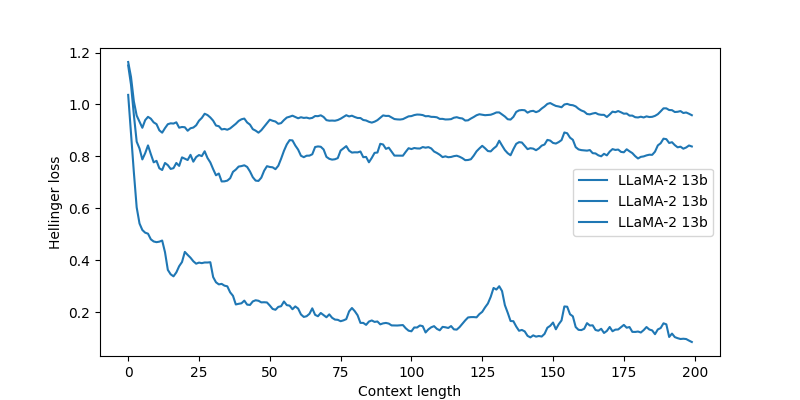

In [ ]:
loss_curve_list = []
num_traj_list = [0,1,2,3,4,5,6,7]
num_traj_list = [0,1,2,3,4]
num_traj_list = [0,1,2]
for num_traj in num_traj_list:
    loss_curve = D_Hel[num_traj * traj_len : (num_traj+1) * traj_len, num_trajs * traj_len + geodesic_steps-1]
    loss_curve_list += [loss_curve]

fig = plt.figure(dpi = 100, figsize=(8,4))
ax = fig.add_subplot(111)
for i, loss_curve in enumerate(loss_curve_list):
    ax.plot(loss_curve, label = traj_names[i], c = color_list[i])
plt.legend()    

plt.ylabel("Hellinger loss")
plt.xlabel("Context length")
save_path = f"{name}_Hellinger_1D.png"
plt.savefig(save_path)
# plt.xscale('log')
# plt.yscale('log')

plt.show()



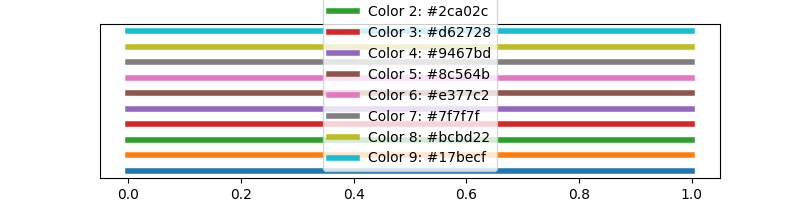

Color 0: #1f77b4
Color 1: #ff7f0e
Color 2: #2ca02c
Color 3: #d62728
Color 4: #9467bd
Color 5: #8c564b
Color 6: #e377c2
Color 7: #7f7f7f
Color 8: #bcbd22
Color 9: #17becf


In [ ]:
import matplotlib.pyplot as plt

# Get the default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot lines with each color in the default color cycle
plt.figure(figsize=(8, 2))
for i, color in enumerate(default_colors):
    plt.plot([0, 1], [i, i], label=f'Color {i}: {color}', color=color, linewidth=4)

plt.legend()
plt.yticks([])
plt.show()

# Print the color codes
for i, color in enumerate(default_colors):
    print(f'Color {i}: {color}')